# My Final Project!
## By Stephen Howard
### I train a model to detect fake news stories based off their title.
### Then,  I train a model to detect them based off the body of the article!
### I save both of these models out to files so that they can be reloaded without needing to be retrained!

### Finally, I set up and API that loads both models and can handle requests for either model. This is done with FastAPI.
#### Notes and reflections on the project at the bottom

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict

2022-12-15 10:28:39.062321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 10:28:39.257823: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-15 10:28:40.016511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-15 10:28:40.016634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Load and combine the data with pandas
#### https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

In [3]:
fake = pd.read_csv('Fake.csv')
fake.drop(['subject', 'date'], axis=1, inplace=True)
fake['label'] = 1
# fake

In [4]:
true = pd.read_csv('True.csv')
true.drop(['subject', 'date'], axis=1, inplace=True)
true['label'] = 0

# Without this, most of the true stories start with "(Reuters) - "
for i, row in true.iterrows():
    if ' - ' in row['text']:
        spot = row['text'].find(' - ')
        true['text'][i] = row['text'][spot+3:]
# true

/tmp/ipykernel_281394/297312797.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true['text'][i] = row['text'][spot+3:]


In [5]:
# combine the fake and true samples and reset the index
df = pd.concat([fake, true]).reset_index(drop=True)
df

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,NATO allies on Tuesday welcomed President Dona...,0
44894,LexisNexis withdrew two products from Chinese ...,"LexisNexis, a provider of legal, regulatory an...",0
44895,Minsk cultural hub becomes haven from authorities,In the shadow of disused Soviet-era factories ...,0
44896,Vatican upbeat on possibility of Pope Francis ...,Vatican Secretary of State Cardinal Pietro Par...,0


In [8]:
# CLEAN UP
# remove special characters and brackets
df['title'] = df['title'].str.replace(r"[@#$&*\[\]]", "", regex=True)  # r"[^a-zA-Z0-9,.:;!?' ]", "")
df['text'] = df['text'].str.replace(r"[@#$&*\[\]]", "", regex=True)

# remove the word video from titles
df['title'] = df['title'].str.replace("video", "", regex=False, case=False)

# lowercase everything
df['title'] = df['title'].str.lower()
df['text'] = df['text'].str.lower()
df

,title,text,label
0,donald trump sends out embarrassing new year’...,donald trump just couldn t wish all americans ...,1
1,drunk bragging trump staffer started russian ...,house intelligence committee chairman devin nu...,1
2,sheriff david clarke becomes an internet joke...,"on friday, it was revealed that former milwauk...",1
3,trump is so obsessed he even has obama’s name...,"on christmas day, donald trump announced that ...",1
4,pope francis just called out donald trump dur...,pope francis used his annual christmas day mes...,1
...,...,...,...
44893,'fully committed' nato backs new u.s. approach...,nato allies on tuesday welcomed president dona...,0
44894,lexisnexis withdrew two products from chinese ...,"lexisnexis, a provider of legal, regulatory an...",0
44895,minsk cultural hub becomes haven from authorities,in the shadow of disused soviet-era factories ...,0
44896,vatican upbeat on possibility of pope francis ...,vatican secretary of state cardinal pietro par...,0


In [9]:
for i in range(10):
    print()
    print(df['title'][12216+i])


massive mi voter fraud uncovered? 59% of detroit vote counting machines didn’t work on election day…ballots may have been counted several times…votes were certified anyway

rosie o’donnell gets a tongue lashing for her attack on barron trump: “why don’t you worry about your own children, and why they don’t want to be with you” 

lou dobbs speaks out on trump, china and taiwan 

tim allen uses “last man standing” episode to mock censorship of speech by snowflake college students…and it’s hilarious! 

wow! huckabee asks nancy pelosi if she’s “racist” or “just dumb” over dr. ben carson comments

what the heck! why was al gore meeting with the trump team today? 

no recount? hillary won ca county with most illegal aliens by stunning margin…ex-ice agent explains how easy it is for illegals to vote 

breaking: obama-appointed judge orders vote recount to begin at noon on monday

trump tweets criticism of china: reminds the world “america-first” is a policy…not a suggestion

chris wallace ca

In [10]:
df['label'].value_counts()

1    23481
0    21417
Name: label, dtype: int64

## Put the data into a huggingface dataset

In [11]:
dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['title', 'text', 'label'],
    num_rows: 44898
})

In [12]:
temp1 = dataset.train_test_split(test_size=0.3, seed=7)
temp2 = temp1['test'].train_test_split(test_size=0.5, seed=42)
# temp2

In [13]:
news = DatasetDict({
    "train": temp1['train'], 
    "validation": temp2['train'], 
    "test": temp2['test']
})
news

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'label'],
        num_rows: 31428
    })
    validation: Dataset({
        features: ['title', 'text', 'label'],
        num_rows: 6735
    })
    test: Dataset({
        features: ['title', 'text', 'label'],
        num_rows: 6735
    })
})

# Prepare the Transformers!!

In [14]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
torch.cuda.get_device_properties('cuda:0')

_CudaDeviceProperties(name='NVIDIA TITAN V', major=7, minor=0, total_memory=12066MB, multi_processor_count=80)

In [15]:
if torch.cuda.is_available():
    print("Running on GPU")
    device = torch.device('cuda')
else:
    print("Running on CPU")
    device = torch.device('cpu')

Running on GPU


In [16]:
id2label = {0: "REAL", 1: "FAKE"}
label2id = {"REAL": 0, "FAKE": 1}

model_ckpt = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=2, id2label=id2label, label2id=label2id).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

# Train a model using the titles of the news articles!
## Prepare the data!

In [17]:
def tokenize_title(batch):
    return tokenizer(batch["title"], padding=True, truncation=True)

In [18]:
news_encoded = news.map(tokenize_title, batched=True, batch_size=None)

Parameter 'function'=<function tokenize_title at 0x7fba303e0700> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [19]:
news_encoded

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'title'],
        num_rows: 31428
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'title'],
        num_rows: 6735
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'title'],
        num_rows: 6735
    })
})

In [20]:
pd.DataFrame(news_encoded['validation'])['label'].value_counts()

1    3533
0    3202
Name: label, dtype: int64

## Start the training!

In [21]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [22]:
from transformers import Trainer, TrainingArguments

def train_model(model, data, model_name, epochs):
    batch_size = 8
    logging_steps = len(data["train"]) // batch_size
    training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  logging_strategy="no",
                                  push_to_hub=False, 
                                  report_to="none",
                                  log_level="error",
                                  save_strategy="no"
                                 )
    
    trainer = Trainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=data["train"],
                  eval_dataset=data["validation"],
                  tokenizer=tokenizer)
    
    trainer.train();
    
    return trainer

In [23]:
trainer = train_model(model, news_encoded, f"{model_ckpt}-finetuned-fake-news", epochs=2)

/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.057832,0.982480,0.982486
2,No log,0.061746,0.985746,0.985750


/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [24]:
preds_output = trainer.predict(news_encoded["test"])
preds_output.metrics

/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.06758199632167816,
 'test_accuracy': 0.9860430586488493,
 'test_f1': 0.9860439949279862,
 'test_runtime': 14.5738,
 'test_samples_per_second': 462.131,
 'test_steps_per_second': 28.887}

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(len(labels), len(labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

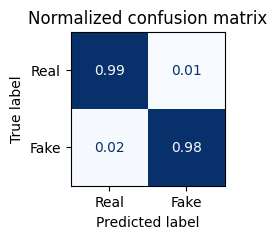

In [26]:
import numpy as np

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(news_encoded["test"]["label"])
labels = ['Real', 'Fake']

plot_confusion_matrix(y_preds, y_valid, labels)

In [27]:
trainer.save_model("models/title_classifier")

# Now train a model that uses the body of the article!

In [ ]:
model_ckpt = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=2, id2label=id2label, label2id=label2id).to(device)

In [31]:
def tokenize_text(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [32]:
news_encoded = news.map(tokenize_text, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

## Train!

In [33]:
trainer = train_model(model, news_encoded, f"{model_ckpt}-finetuned-fake-news", epochs=2)

/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.005256,0.998664,0.998664
2,No log,0.008214,0.998515,0.998515


/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [34]:
preds_output = trainer.predict(news_encoded["test"])
preds_output.metrics

/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.008866696618497372,
 'test_accuracy': 0.998218262806236,
 'test_f1': 0.9982183052453911,
 'test_runtime': 36.2479,
 'test_samples_per_second': 185.804,
 'test_steps_per_second': 11.614}

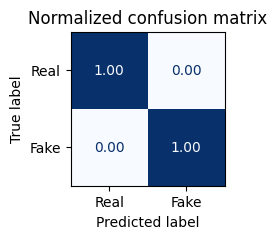

In [35]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(news_encoded["test"]["label"])
labels = ['Real', 'Fake']

plot_confusion_matrix(y_preds, y_valid, labels)

In [36]:
trainer.save_model("models/text_classifier")

# Set up the API!
### This next cell will load everything, set up the server, and start it. No prior cells need to be run!
## Example requests: 
### Send a POST request to the '/title/' endpoint with the title in the request body for the title model!
#### curl -XPOST -H "Content-Type: application/json" -d '{"text": "insert title here"}' http://localhost:8000/title/
### Send a POST request to the '/text/' endpoint with the story in the request body for the text model!
#### curl -XPOST -H "Content-Type: application/json" -d '{"text": "insert story here"}' http://localhost:8000/text/

In [38]:
from fastapi import FastAPI
from typing import Dict
import asyncio
import uvicorn
import torch
from transformers import logging, AutoTokenizer, AutoModelForSequenceClassification

# or else the logger will say a bunch of random stuff...
logging.set_verbosity_error()

title_model_ckpt = "models/title_classifier"
text_model_ckpt = "models/text_classifier"

title_tokenizer = AutoTokenizer.from_pretrained(title_model_ckpt)
title_model = AutoModelForSequenceClassification.from_pretrained(title_model_ckpt, num_labels=2)

text_tokenizer = AutoTokenizer.from_pretrained(text_model_ckpt)
text_model = AutoModelForSequenceClassification.from_pretrained(text_model_ckpt, num_labels=2)

app = FastAPI()

@app.post("/title/")
def infer(data: Dict[str, str]):
    text = data['text']
    print("Received title:", text)
    
    tokenized = title_tokenizer.encode(text, return_tensors='pt')
    output = title_model(tokenized)
    # output.logits
    preds = torch.argmax(output.logits, axis=1)
    pred = preds.item()
    
    if pred == 0:
        print("Result: Real")
        return "Real"
    else:
        print("Result: Fake")
        return "Fake"
    
@app.post("/text/")
def infer_text(data: Dict[str, str]):
    text = data['text']
    print("Received text:", text)
    
    tokenized = text_tokenizer.encode(text, return_tensors='pt')
    output = text_model(tokenized)
    # output.logits
    preds = torch.argmax(output.logits, axis=1)
    pred = preds.item()
    
    if pred == 0:
        print("Result: Real")
        return "Real"
    else:
        print("Result: Fake")
        return "Fake"

    
config = uvicorn.Config(app)
server = uvicorn.Server(config)
await server.serve()

INFO:     Started server process [281394]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Received text: Nato allies on Tuesday
Result: Real
INFO:     127.0.0.1:47842 - "POST /text/ HTTP/1.1" 200 OK
Received text: check out this crazy video
Result: Fake
INFO:     127.0.0.1:59902 - "POST /text/ HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [281394]


# Thoughts on the project:
* First off, setting up the API portion of this lab was really awesome! It wasn't too hard to do, and it's incredibly satisfying to see it work!
* This project was *very* unexpected for me. I thought that I would have to put in work to try and help the transformer learn this task! But nope, my efforts were spent in the other direction, trying to make it perform worse! As you can see from the results above, these models were able to figure this problem out with incredible accuracy. I was immediately afraid that something in the data was, in essence, giving away the answers so I tried to remove some things from the data. I also made sure that the data was correctly balanced in all datasets. And yet, the transformer still figured it out too well!
* I was planning to try a different transformer model to compare with these, but it doesn't make sense to since these are already almost perfect!
* This really taught me the power of transformers, and also gave me the experience of combing through data looking for hints that the transformer could be using!
* Given more time, I would have messed with the data even more to try and confuse the models, to see if I can manage to lower their accuracy.